In [1]:

from matplotlib import pyplot as plt
import sys, os
import scipy, pickle
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import jax.random as jr
from ilqr_vae_jax import defaults, typs, dynamics, likelihood, vae, encoder, coupler, prior
from ilqr_vae_jax.typs import iLQRHParams, Dims, VanillaParams 
from ilqr_vae_jax.dynamics import VRNN
from diffilqrax import lqr, ilqr
from diffilqrax import typs as ilqr_typs
from joblib import Parallel, delayed
import optax
import imageio
from PIL import Image as PILImage
from IPython.display import Image
jax.config.update("jax_enable_x64", True)
%load_ext autoreload
%autoreload 2


In [2]:

dir_name = "partially_observed2"
typ_attractor = "linear"  #
os.makedirs(dir_name, exist_ok = True)
true_n = 2
true_m = 1 #true_n
n_out = 40
T_rec =  10000
n = 20
sigma_noise = 0.02
seed = 12
noise_type = "gaussian"
key = jr.PRNGKey(seed)
A = jnp.asarray([[0.9, 0.1], [-0.1, 0.9]])
T = 100 
num_datapoints = int((T_rec/T))
batch_size = 1 #np.minimum(10, num_datapoints)
num_batches_per_epoch = int(num_datapoints/batch_size)
 
params_dct = {"A": A, "T": T, "n": n, "n_out": n_out, "sigma_noise": sigma_noise, "seed": seed, "noise_type": noise_type}
np.save(f"{dir_name}/params.npy", params_dct)
dims = Dims(n = true_n, m = true_m, n_out = n_out, horizon = 2*T_rec)


true_c = jax.random.normal(jr.PRNGKey(1), shape = (n_out, true_n))/jnp.sqrt(true_n)
dyn_params = typs.VanillaExtParams(a = A, b = jax.random.normal(key = key, shape = (true_n,true_m)), bias = jnp.zeros((true_n,)), b_ext = jax.random.normal(key = jr.PRNGKey(123), shape = (true_n,n_out))) #, sigma = 0.1)

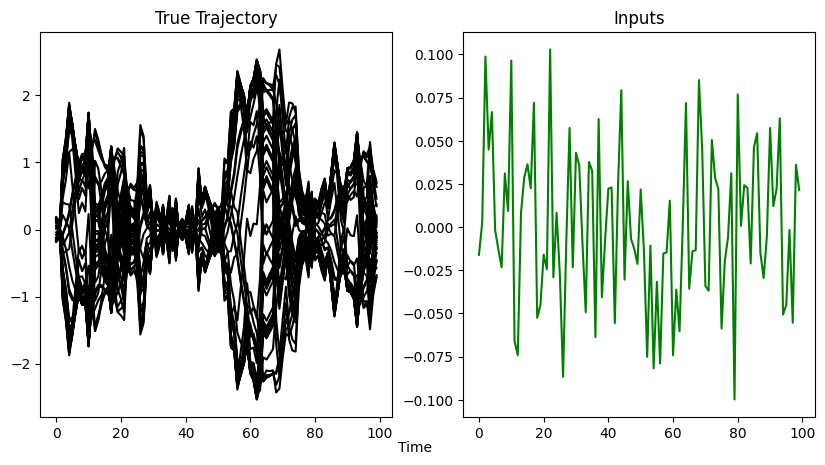

<Figure size 640x480 with 0 Axes>

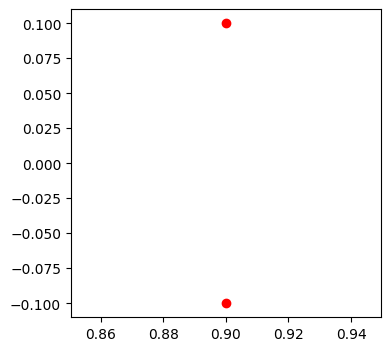

In [3]:
key, subkey = jr.split(key)
inputs = 0.05*jr.normal(key = jr.PRNGKey(4), shape = (2*T_rec,true_m)) ##here, 1D input
ys = VRNN(phi = lambda x : x, dims=dims).run_dynamics(dyn_params, jnp.zeros(dims.n), inputs, None, None)@true_c.T
mean_ys = jnp.mean(ys.reshape((-1, ys.shape[-1])), axis = 0)
std_ys = jnp.std(ys.reshape((-1, ys.shape[-1])), axis = 0)
data = (ys.reshape((-1,T, n_out)) - mean_ys)/std_ys
us = inputs.reshape((-1,T, true_m))
train_data = data[:num_datapoints], jnp.zeros((num_datapoints, true_m)), jnp.zeros_like(data[:num_datapoints])
test_data = data[num_datapoints:], jnp.zeros((num_datapoints, true_m)), jnp.zeros_like(data[num_datapoints:])
train_inputs = us[:num_datapoints]
test_inputs = us[num_datapoints:]
ys = train_data[0]


###
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(ys[0], color = "black")
axes[0].set_title("True Trajectory")
plt.figure()
axes[1].plot(inputs[:100], color = "green", label = "Inputs")
axes[1].set_title("Inputs")
fig.text(0.5, 0.04, 'Time', ha='center')


##viz the true model
true_eigs = jnp.linalg.eigvals(A)
plt.figure(figsize = (4,4))
plt.scatter(np.real(true_eigs), np.imag(true_eigs), color = "red", label = "True Eigenvalues")

# learned_dyn_params = vae_module.params.dyn_params
# keys = jr.split(key, n_data)
# us = np.load(f"{dir_name}/inputs_final.npy")[:10]
# learned_trajs = jax.vmap(dyn_module.run_dynamics, in_axes = (None, None, 0, None, 0))(learned_dyn_params, jnp.zeros(n), us, None, jnp.zeros((10, T, n_out)))
# def learned_dyn(x):
#     nx = dyn_module.dynamics_t(learned_dyn_params, x, jnp.zeros(m), None, jnp.zeros(n_out))
#     return nx



## Example training an LFADS model

In [4]:
#################
eigs = np.linalg.eigvals(A)
key0 = jr.PRNGKey(seed)
print("running running")

    #pass 
###############

total_num_batches = 3000
training_hparams = defaults.default_training_hparams
training_hparams = training_hparams._replace(batch_size = batch_size)
training_hparams = training_hparams._replace(kl_warmup_end = -1)
total_num_epochs = int(total_num_batches/num_batches_per_epoch)
print(total_num_epochs)
training_hparams = training_hparams._replace(num_epochs = total_num_epochs)
training_hparams = training_hparams._replace(total_num_datapoints = len(train_data))
warmup_steps = num_batches_per_epoch*int(0.2*total_num_epochs)
decay_steps = num_batches_per_epoch*int(0.8*total_num_epochs)
lr_scheduler = optax.warmup_cosine_decay_schedule(init_value = 0, peak_value = 5e-3, warmup_steps =  warmup_steps, decay_steps = decay_steps)
training_hparams = training_hparams._replace(lr_scheduler = lr_scheduler)
training_hparams = training_hparams._replace(clip_grads = True)

m = 5
n = 100
dims = typs.Dims(n_out =  n_out, n = n, m = m, m_encoder = m, horizon = T, n_controller = 64, m_controller = 64, n_encoder = 64)
train_dataloader = defaults.Dataloader(dims, train_data, batch_size, test_data)
dyn_module = dynamics.VRNN(dims = dims, phi = lambda x : x, rad = 0.5) 
prior_module = prior.Gaussian(dims = dims, full_ic = True) 
likelihood_module = likelihood.Gaussian(dims = dims, scale = 0.1) 
encoder_module = encoder.BiRNN(dims = dims)
coupler_module = coupler.GRUController(dims = dims) 
vae_module = vae.VAE(dynamics = dyn_module, coupler = coupler_module, prior = prior_module, likelihood = likelihood_module, encoder = encoder_module, dataloader = train_dataloader, dims = dims, inputs_allowed=1, saving_dir = dir_name, training_hparams=training_hparams, dropout = None, dropout_rate = 0.99, shmap = False)
vae_module.verbose = True
vae_module.save = True
vae_module.init_seed = seed + 1
vae_module.checkpoint = 50 # checkpoint every 50 iterations
vae_module.train()


running running
30
epoch 0 | time = 6.329146146774292| loss: 4.2168151367750655 ~ ll: -15863.606500900416. entropy: 171.27128693731592. log_prior: -1174.9253331371672
epoch 1 | time = 9.68856430053711| loss: 0.6541981966420376 ~ ll: -1560.7064046325422. entropy: 101.86113712178661. log_prior: -1157.947519057395
epoch 2 | time = 11.315056324005127| loss: 0.3854893817117147 ~ ll: -461.76362899278325. entropy: 15.132276752125366. log_prior: -1095.326174606201
epoch 3 | time = 12.958187103271484| loss: 0.22302308955017888 ~ ll: 92.99789827687094. entropy: 47.37107937472684. log_prior: -1032.4613358523131
epoch 4 | time = 14.573427200317383| loss: 0.41031915274987596 ~ ll: -740.9291497229787. entropy: 114.55297774808444. log_prior: -1014.9004390246101
epoch 5 | time = 16.205878019332886| loss: 0.1754498321217503 ~ ll: 161.71122659720683. entropy: 108.46610153674759. log_prior: -971.976656620956
epoch 6 | time = 17.830915212631226| loss: 0.13651845600239432 ~ ll: 263.50992201369786. entropy:

R² of pred_outputs to true_test_outputs: 0.9895938560607391
R² of pred_inputs to true_test_inputs (with fitting): 0.955156941130309


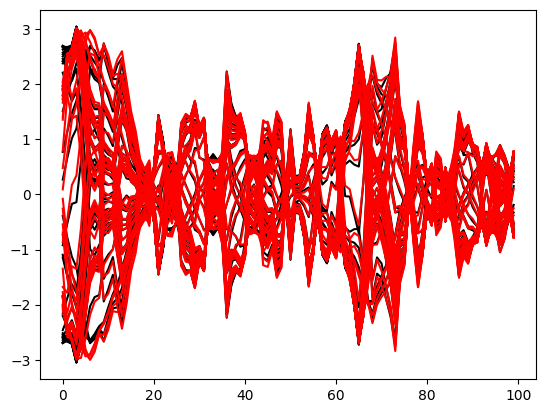

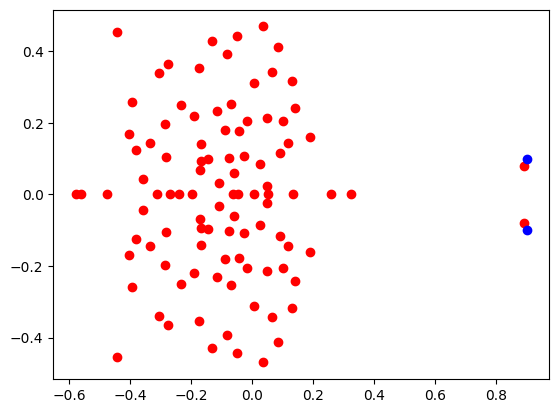

In [5]:

pred_inputs = np.load(f"{dir_name}/inputs.npy").reshape(-1,m)
pred_outputs = np.load(f"{dir_name}/predictions.npy")
true_test_inputs = test_inputs.reshape(-1,true_m)
true_test_outputs = test_data[0].reshape(-1,n_out)
pred_outputs = pred_outputs.reshape(-1,n_out)


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
r2_pred_to_true = r2_score(true_test_outputs.reshape(-1,n_out), pred_outputs.reshape(-1,n_out))
print(f"R² of pred_outputs to true_test_outputs: {r2_pred_to_true}")



# Fit a linear regression model for pred_inputs to true_test_inputs
model = LinearRegression()
nn_inputs = pred_inputs.shape[0]
model.fit(pred_inputs[:int(nn_inputs/2)], true_test_inputs[:int(nn_inputs/2)])
predicted_true_inputs = model.predict(pred_inputs[int(nn_inputs/2):])

# Calculate R² for the fitted model
r2_inputs_to_true = r2_score(true_test_inputs[int(nn_inputs/2):], predicted_true_inputs)
print(f"R² of pred_inputs to true_test_inputs (with fitting): {r2_inputs_to_true}")

np.savetxt(f"{dir_name}/r2_scores.txt", np.array([r2_pred_to_true, r2_inputs_to_true]))

## plot what the activity looks like
plt.figure()
plt.plot(true_test_outputs[:100], color = "black", label = "True Outputs")
plt.plot(pred_outputs[:100], color = "red", label = "Predicted Outputs")
#### dynamics comp
a = vae_module.params.dyn_params.a
eigs = np.linalg.eigvals(a)
plt.figure()
plt.scatter(np.real(eigs), np.imag(eigs), color = "red", label = "Learned Eigenvalues")
plt.scatter(np.real(true_eigs), np.imag(true_eigs), color = "blue", label = "True Eigenvalues")

## Example training an iLQR-VAE model

In [26]:
#################
eigs = np.linalg.eigvals(A)
key0 = jr.PRNGKey(seed)
print("running running")

    #pass 
###############

total_num_batches = 20000

training_hparams = defaults.default_training_hparams
training_hparams = training_hparams._replace(batch_size = batch_size)
training_hparams = training_hparams._replace(kl_warmup_end = -1)
total_num_epochs = int(total_num_batches/num_batches_per_epoch)
print(total_num_epochs)
training_hparams = training_hparams._replace(num_epochs = total_num_epochs)
training_hparams = training_hparams._replace(total_num_datapoints = len(train_data))
warmup_steps = num_batches_per_epoch*int(0.2*total_num_epochs)
decay_steps = num_batches_per_epoch*int(0.8*total_num_epochs)
lr_scheduler = optax.exponential_decay(init_value = 1e-3, decay_rate = 0.95, transition_steps = 2500)
training_hparams = training_hparams._replace(lr_scheduler = lr_scheduler)
training_hparams = training_hparams._replace(clip_grads = False)

m = 2
n = 2
##dimensions : here, we have an ilqr model so we use the identity coupling (i.e the inputs are directly the output of ilqr, without requiring any further step)
#thus, we will use m_encoder = m_ilqr = m
dims = typs.Dims(n_out =  n_out, n = n, m = m, m_encoder = m, horizon = T)
train_dataloader = defaults.Dataloader(dims, train_data, batch_size, test_data)
dyn_module = dynamics.VRNN(dims = dims, phi = lambda x : x, rad = 0.5) 
prior_module = prior.Gaussian(dims = dims, full_ic = (m ==n), prior_logstd = 0.1)
likelihood_module = likelihood.Gaussian(dims = dims, scale =0.1)
encoder_module = encoder.iLQR(likelihood = likelihood_module, prior = prior_module, dynamics = dyn_module, dims = dims, ilqr_hparams = iLQRHParams(n_beg = int(n/m), dt = 0.1, use_linesearch = False)) 
coupler_module = coupler.IDCoupling(dims = dims) 
vae_module = vae.VAE(dynamics = dyn_module, coupler = coupler_module, prior = prior_module, likelihood = likelihood_module, encoder = encoder_module, dataloader = train_dataloader, dims = dims, inputs_allowed=1, saving_dir = dir_name, training_hparams=training_hparams, dropout = None, dropout_rate = 0.99, shmap = False)
vae_module.verbose = True
vae_module.save = True
vae_module.init_seed = seed + 1
vae_module.checkpoint = 50 # checkpoint every 50 iterations
vae_module.train()


running running
200
epoch 0 | time = 12.467257738113403| loss: 2.038675146557906 ~ ll: -6370.509290476198. entropy: -739.6286268479436. log_prior: -1044.5626689074825
epoch 1 | time = 23.318464040756226| loss: 0.42384409352958774 ~ ll: 39.775060572451146. entropy: -714.5000708741194. log_prior: -1020.6513638166828
epoch 2 | time = 27.181302070617676| loss: 0.25693694996093286 ~ ll: 633.3150493991593. entropy: -697.5116922141768. log_prior: -963.5511570287147
epoch 3 | time = 31.053059101104736| loss: 0.17754166305576605 ~ ll: 876.4367701243727. entropy: -680.8550080885692. log_prior: -905.748414258867
epoch 4 | time = 34.94022178649902| loss: 0.11920213204865242 ~ ll: 1046.0076031676072. entropy: -670.6192545153704. log_prior: -852.1968768468464
epoch 5 | time = 38.882269859313965| loss: 0.06876690483313805 ~ ll: 1191.5385087789891. entropy: -660.3741982381298. log_prior: -806.2319298734121
epoch 6 | time = 42.77804684638977| loss: 0.019094001270634785 ~ ll: 1332.5597092025134. entropy

KeyboardInterrupt: 

R² of pred_outputs to true_test_outputs: 0.9999558387164879
R² of pred_inputs to true_test_inputs (with fitting): 0.06241637447160897


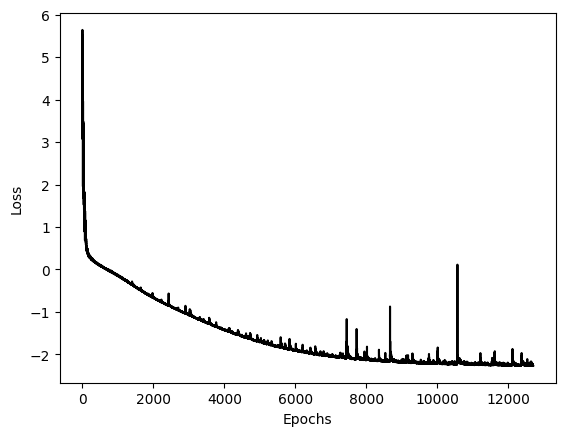

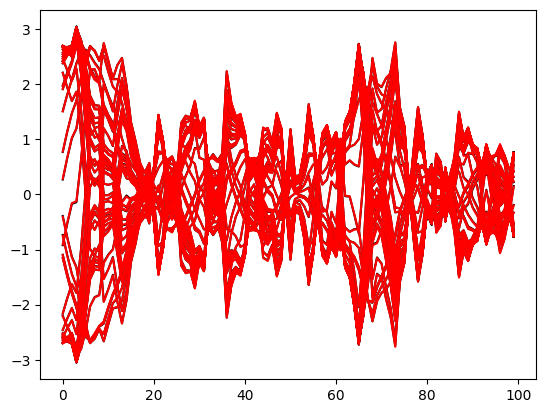

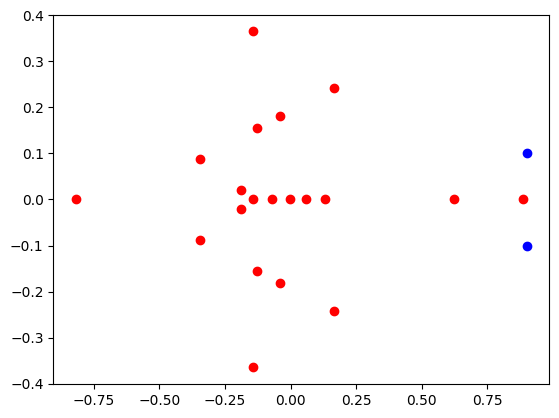

In [24]:
### plot the loss
plt.figure()
plt.plot(vae_module.losses, color = "black")
plt.ylabel("Loss")
plt.xlabel("Epochs")


pred_inputs = np.load(f"{dir_name}/inputs.npy").reshape(-1,m)
pred_outputs = np.load(f"{dir_name}/predictions.npy") 
true_test_inputs = test_inputs.reshape(-1,true_m)
true_test_outputs = test_data[0].reshape(-1,n_out)
pred_outputs = pred_outputs.reshape(-1,n_out)


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
r2_pred_to_true = r2_score(true_test_outputs.reshape(-1,n_out), pred_outputs.reshape(-1,n_out))
print(f"R² of pred_outputs to true_test_outputs: {r2_pred_to_true}")



# Fit a linear regression model for pred_inputs to true_test_inputs
model = LinearRegression()
nn_inputs = pred_inputs.shape[0]
model.fit(pred_inputs[:int(nn_inputs/2)], true_test_inputs[:int(nn_inputs/2)])
predicted_true_inputs = model.predict(pred_inputs[int(nn_inputs/2):])

# Calculate R² for the fitted model
r2_inputs_to_true = r2_score(true_test_inputs[int(nn_inputs/2):], predicted_true_inputs)
print(f"R² of pred_inputs to true_test_inputs (with fitting): {r2_inputs_to_true}")

np.savetxt(f"{dir_name}/r2_scores.txt", np.array([r2_pred_to_true, r2_inputs_to_true]))

## plot what the activity looks like
plt.figure()
plt.plot(true_test_outputs[:100], color = "black", label = "True Outputs")
plt.plot(pred_outputs[:100], color = "red", label = "Predicted Outputs")

## dynamics comp
a = vae_module.params.dyn_params.a
eigs = np.linalg.eigvals(a)
plt.figure()
plt.scatter(np.real(eigs), np.imag(eigs), color = "red", label = "Learned Eigenvalues")
plt.scatter(np.real(true_eigs), np.imag(true_eigs), color = "blue", label = "True Eigenvalues")
